In [78]:
import torch
import torch.nn as nn
import numpy as np

import os
import imageio
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from dataset import get_rays
from rendering import rendering
from model import Voxels, Nerf
from ml_helpers import training

In [79]:
test_o, test_d, test_target_px_values = get_rays('fox', mode='test')

In [80]:
device = 'cpu'
tn = 8.
tf = 12.

In [81]:
model = torch.load('model_nerf').to(device)

In [82]:
def mse2psnr(mse):
    return 20 * np.log10(1 / np.sqrt(mse))


@torch.no_grad()
def test(model, o, d, tn, tf, nb_bins=100, chunk_size=10, H=400, W=400, target=None):
    
    o = o.chunk(chunk_size)
    d = d.chunk(chunk_size)
    
    image = []
    for o_batch, d_batch in zip(o, d):
        img_batch = rendering(model, o_batch, d_batch, tn, tf, nb_bins=nb_bins, device=o_batch.device)
        image.append(img_batch) # N, 3
    image = torch.cat(image)
    image = image.reshape(H, W, 3).cpu().numpy()
    
    if target is not None:
        mse = ((image - target)**2).mean()
        psnr = mse2psnr(mse)
    
    if target is not None: 
        return image, mse, psnr
    else:
        return image

In [83]:
from tqdm import tqdm
def plot_rays(o: np.array, d: np.array, t: float):
    fig = plt.figure(figsize=(12, 12))
    ax = plt.axes(projection='3d')
    
    pt1 = o
    pt2 = o + t * d
    for p1, p2 in tqdm(zip(pt1[::100], pt2[::100])):
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]])
        
    plt.show()

In [84]:
len(test_o)

10

In [85]:
torch.from_numpy(test_o[0]).shape

torch.Size([160000, 3])

1600it [00:02, 743.08it/s]


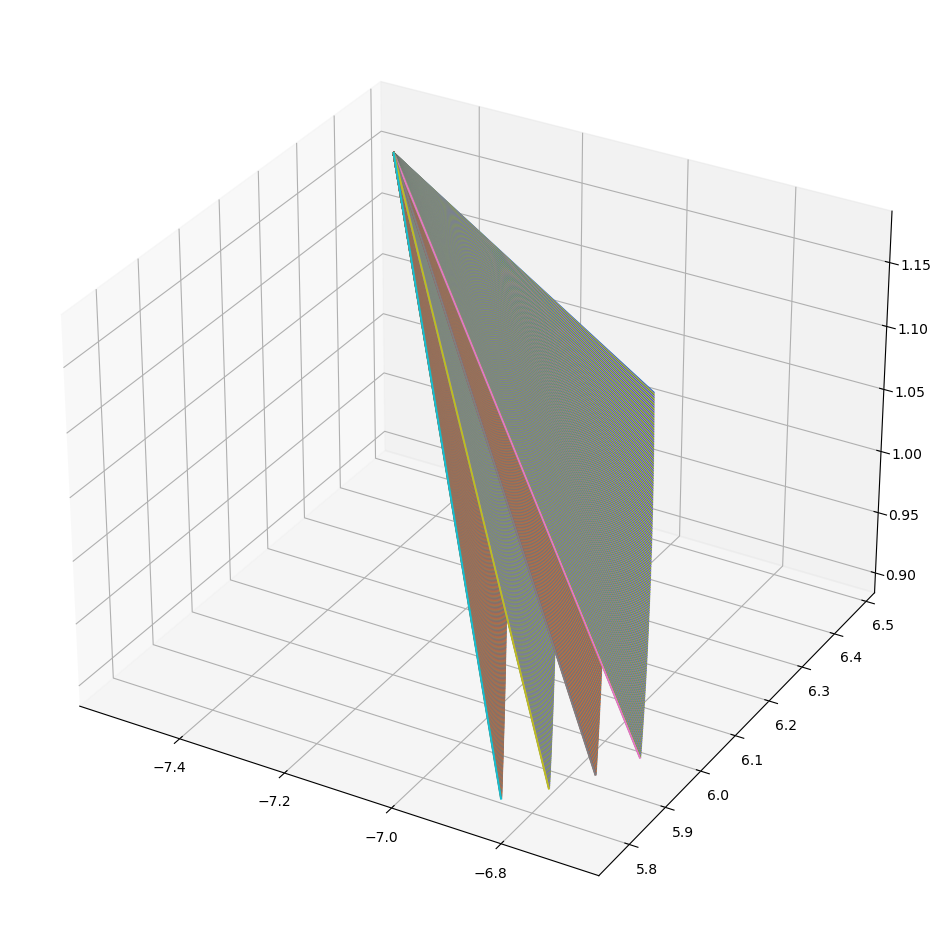

1600it [00:02, 692.75it/s]


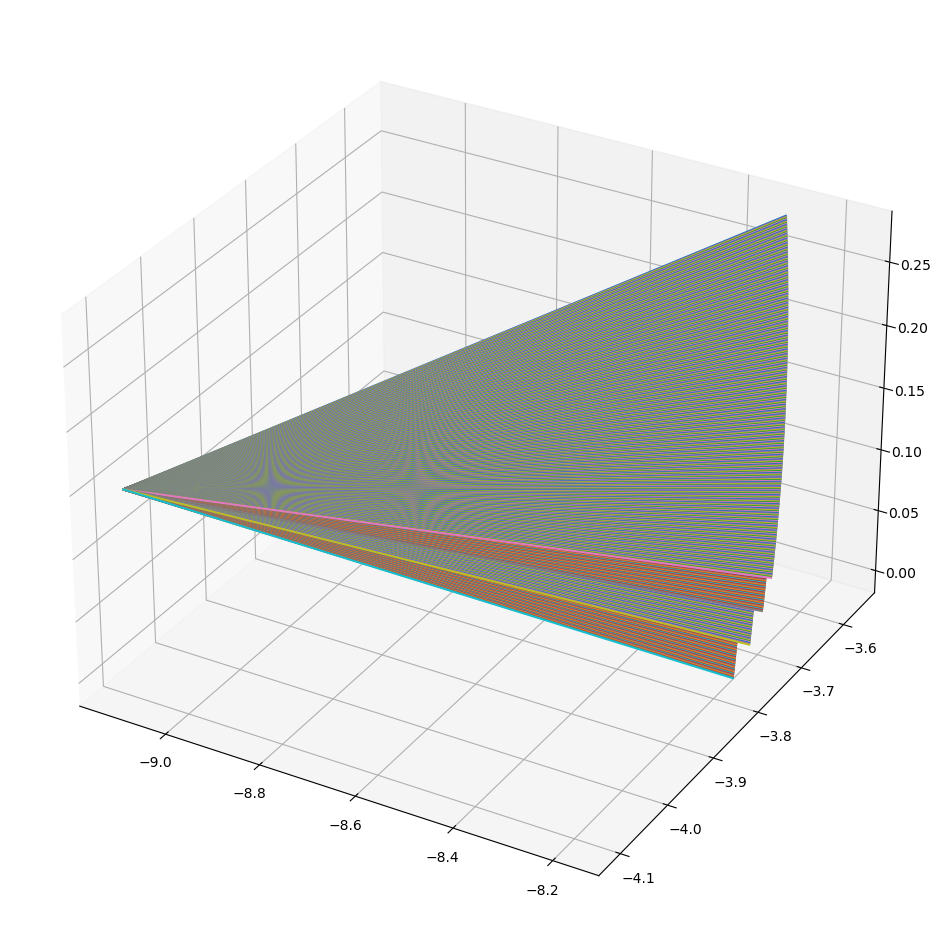

1600it [00:02, 693.72it/s]


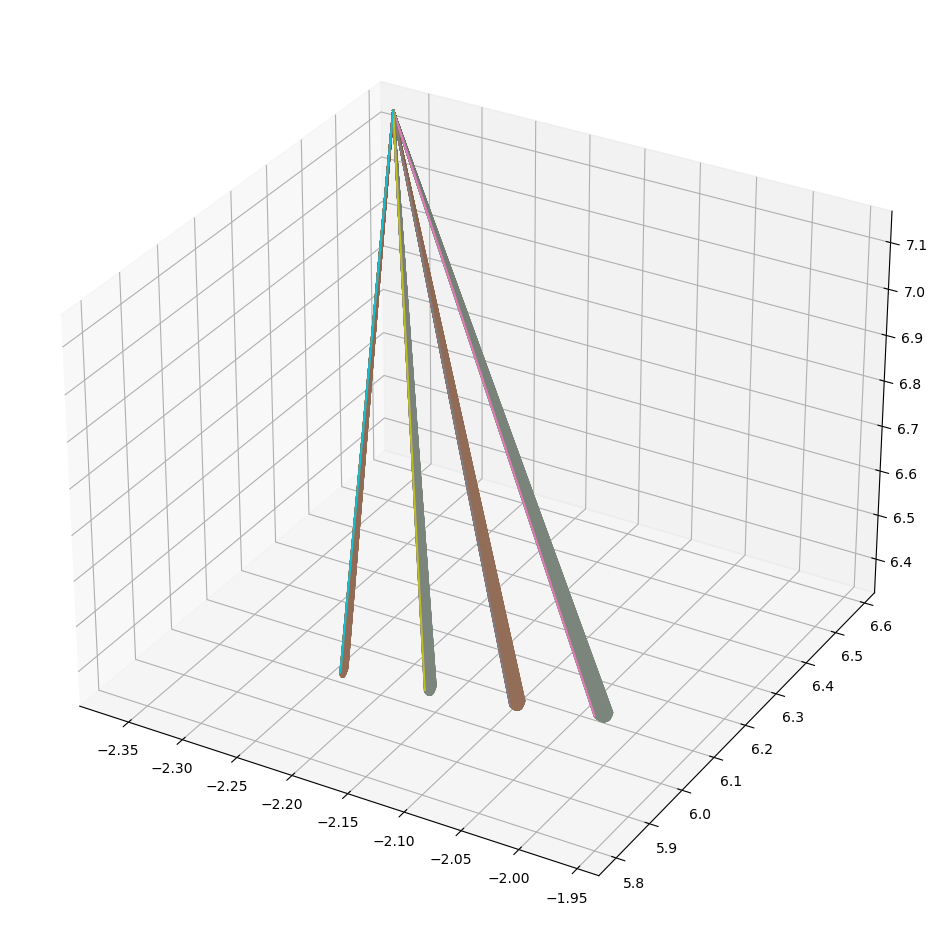

1600it [00:02, 748.16it/s]


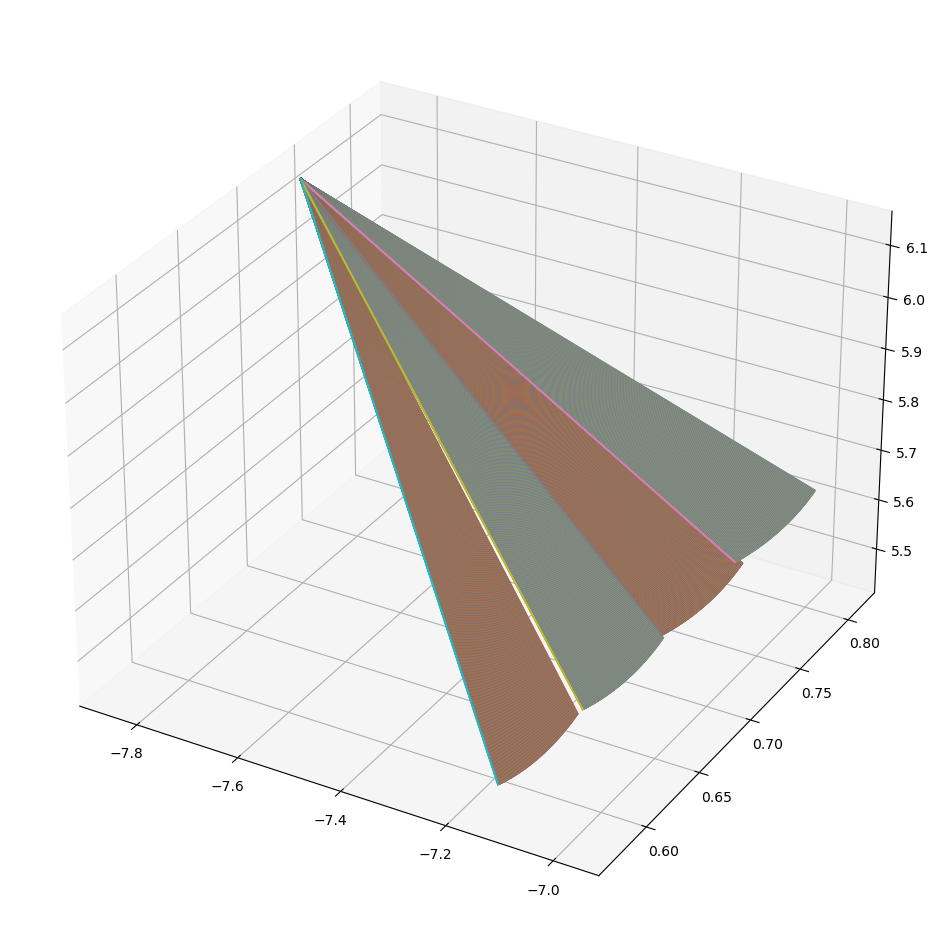

1600it [00:02, 723.51it/s]


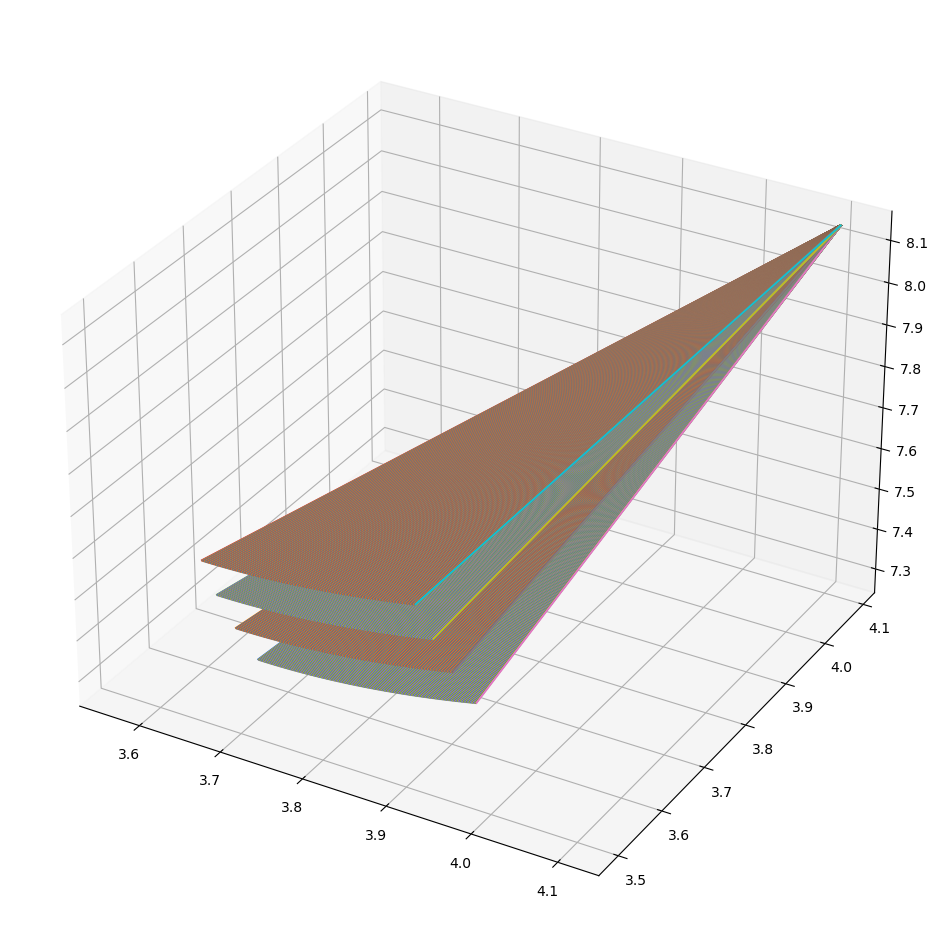

1600it [00:02, 689.31it/s]


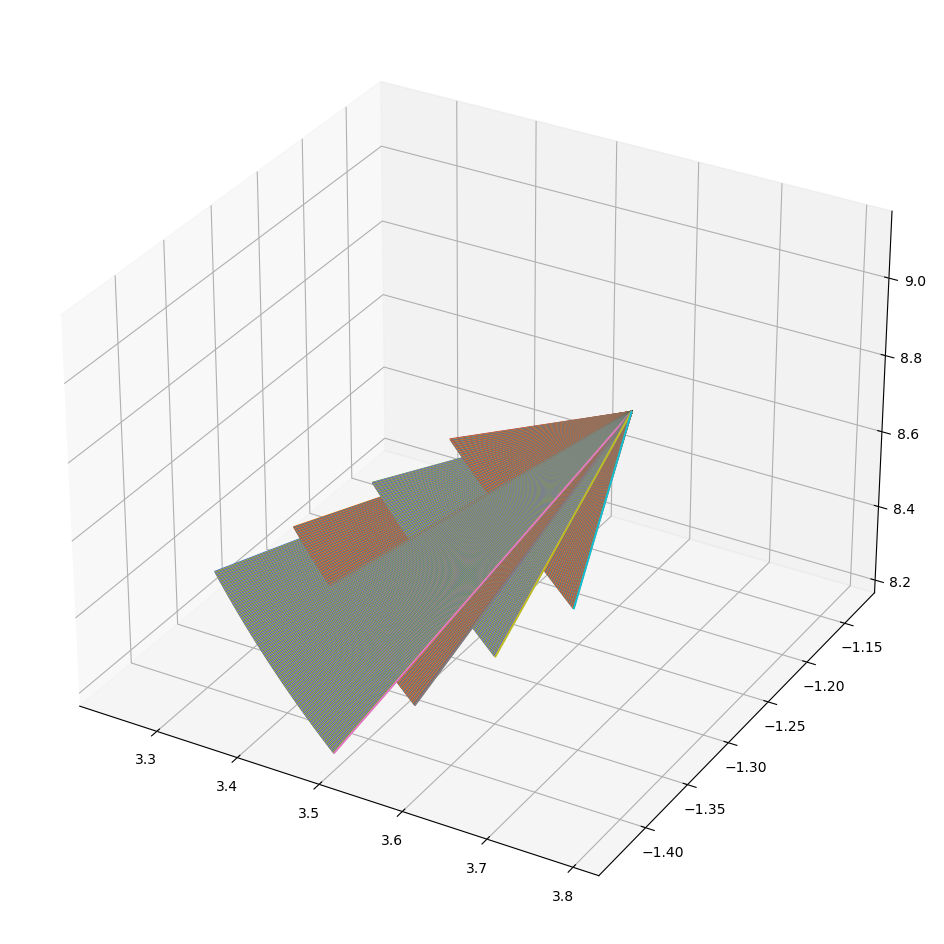

1600it [00:02, 744.03it/s]


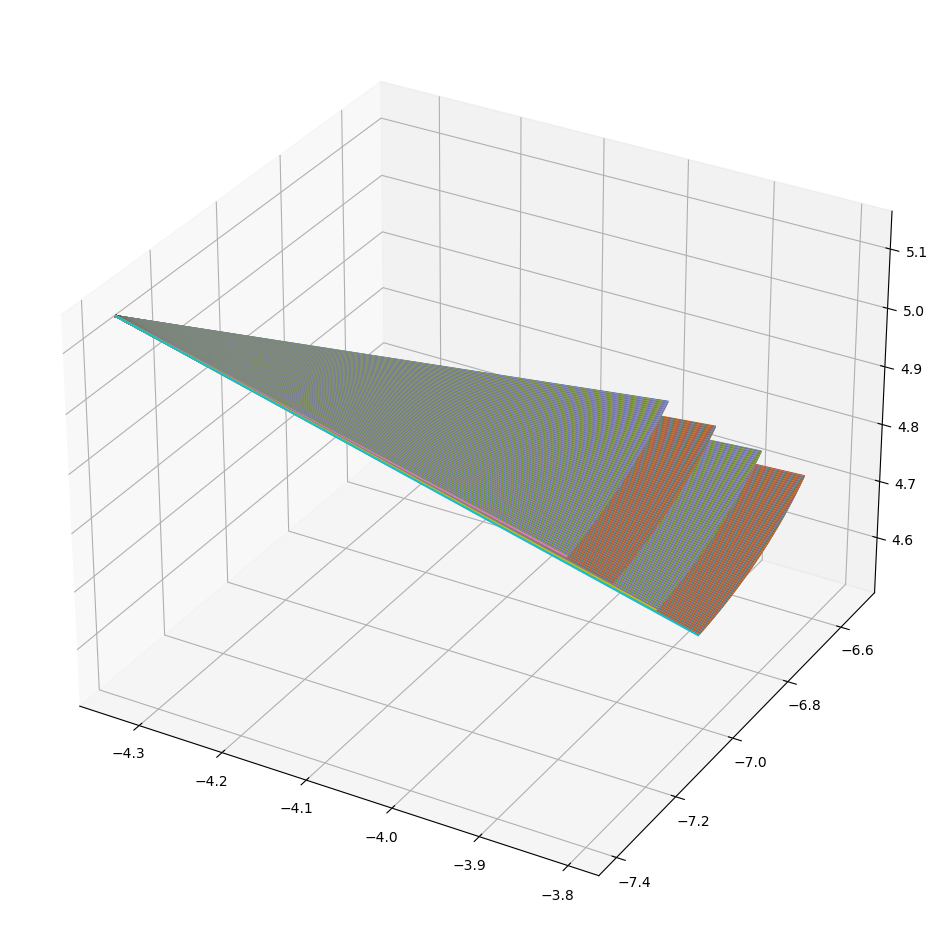

1600it [00:02, 765.54it/s]


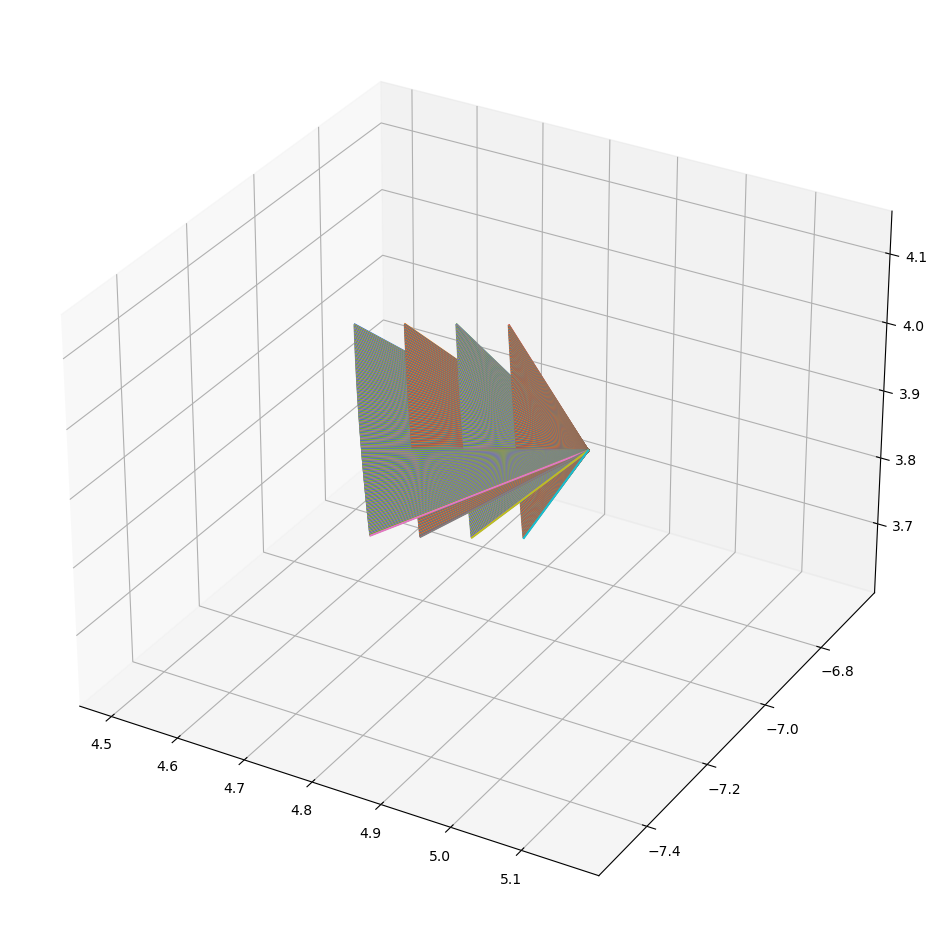

1600it [00:02, 777.24it/s]


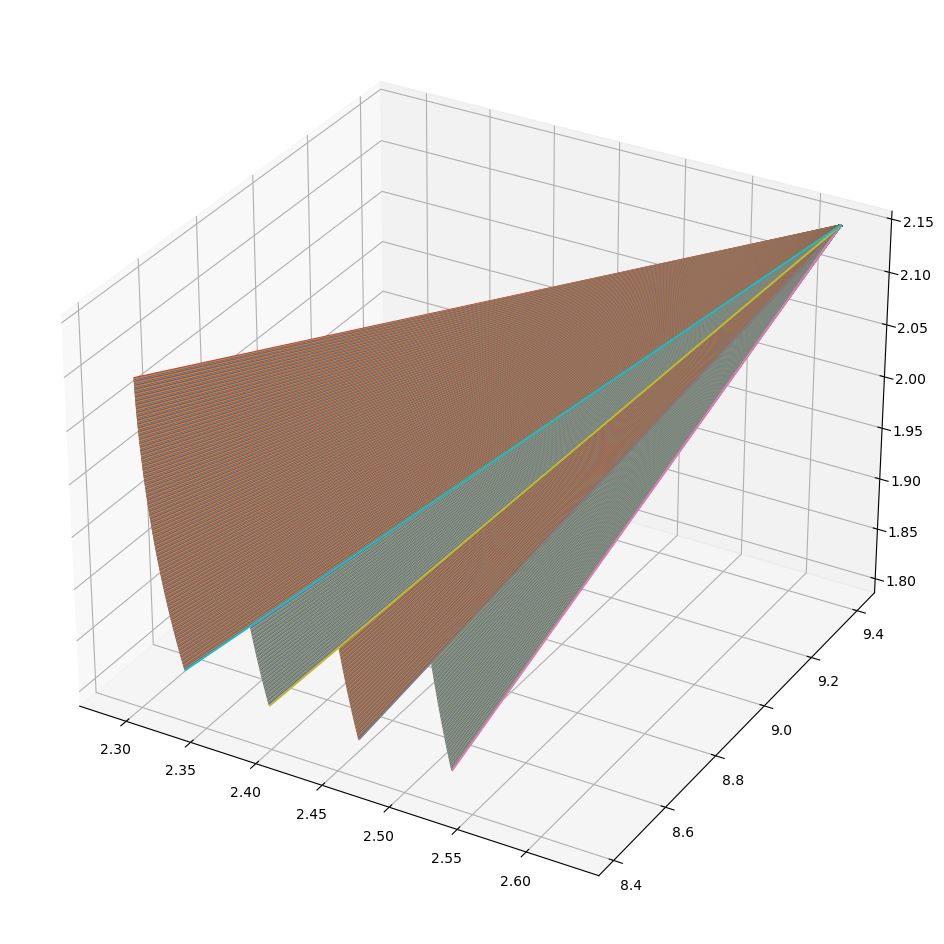

1600it [00:02, 747.19it/s]


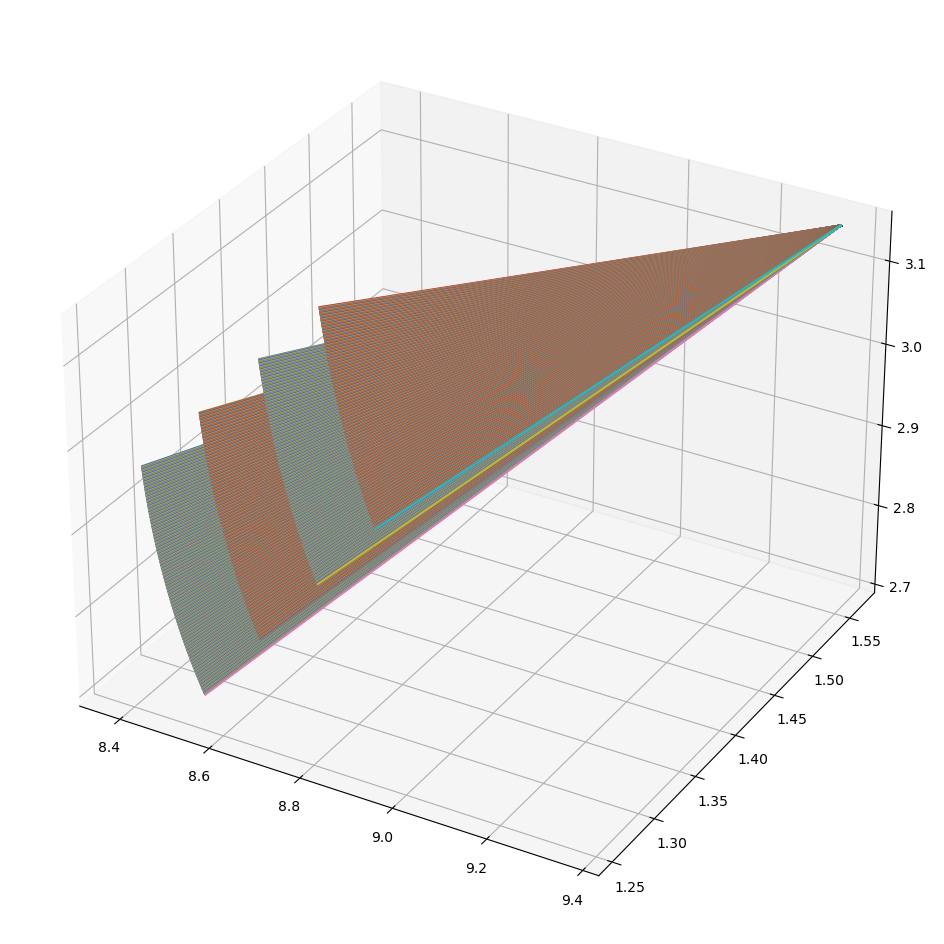

In [86]:
for i in range(len(torch.from_numpy(test_o))): 
    plot_rays(torch.from_numpy(test_o[i]),torch.from_numpy(test_d[i]), 1)

160000it [01:45, 1519.38it/s]


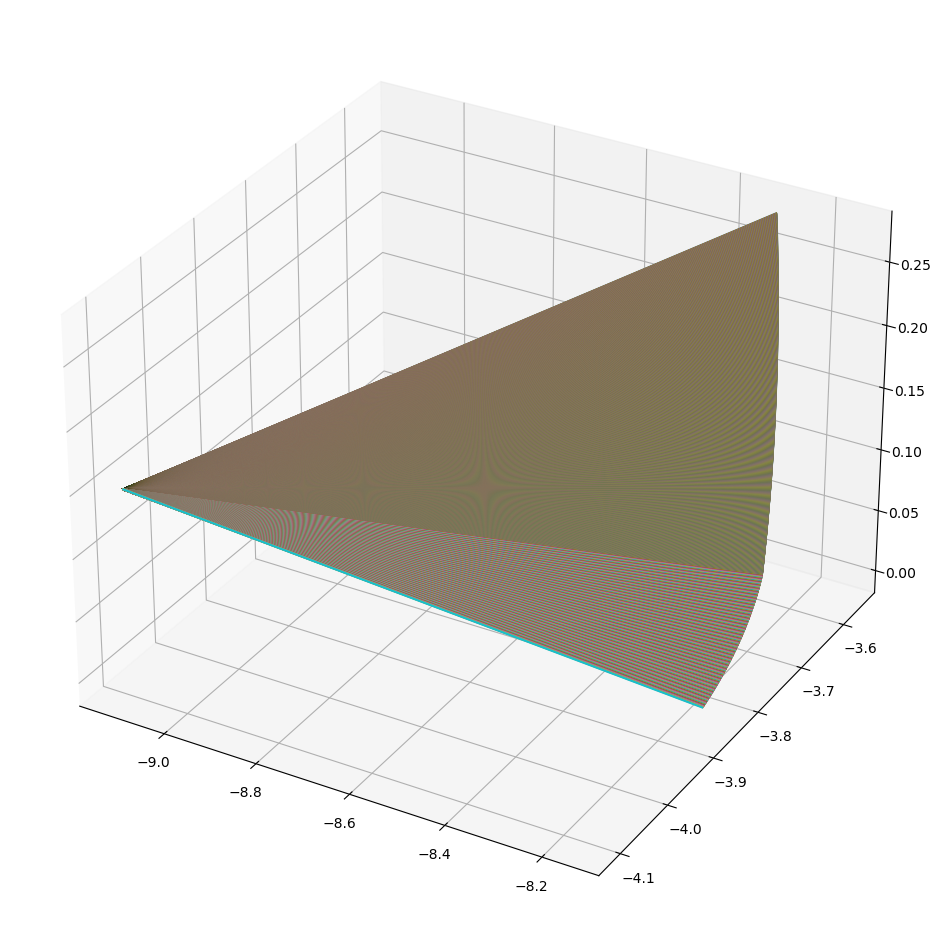

In [51]:
plot_rays(torch.from_numpy(test_o[1]),torch.from_numpy(test_d[1]), 1)

1600it [00:01, 1508.49it/s]


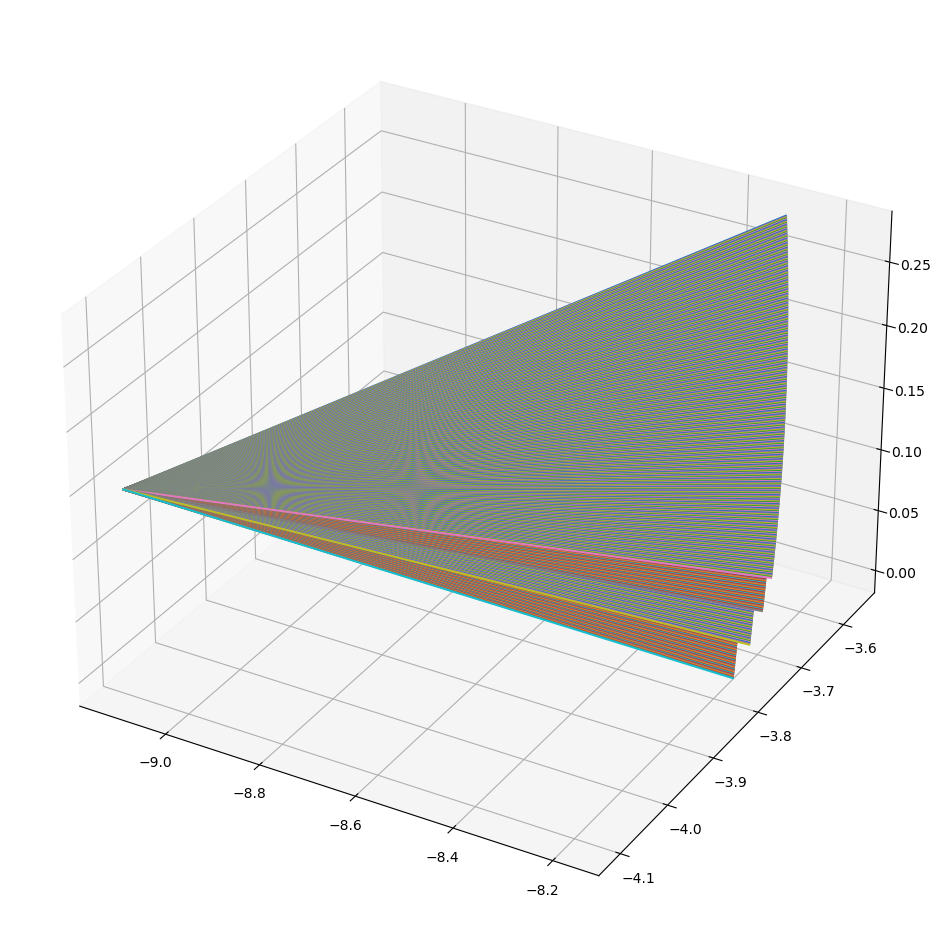

In [48]:
plot_rays(torch.from_numpy(test_o[1]),torch.from_numpy(test_d[1]), 1)

In [89]:
img, mse, psnr = test(model, torch.from_numpy(test_o[0]).to(device).float(), torch.from_numpy(test_d[0]).to(device).float(),
                tn, tf, nb_bins=100, chunk_size=10, target=test_target_px_values[0].reshape(400, 400, 3))

print(psnr)

28.032181183113728


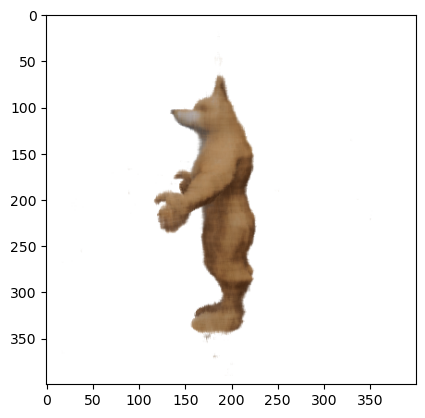

In [14]:
plt.imshow(img)